# Domain Adaptation Using Transfer Learning
In this notebook, we will guide through each step from training of the source dataset, to the transfer learning of BERT model to the target dataset. All the dataset are from Kaggle, and the notebook is run on Kaggle.

In [1]:
!pip install transformers

In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score

# Torch ML libraries
import transformers
from transformers import BertModel, BertTokenizer, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

# Misc.
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Set RANDOM SEED for reproducibility
RANDOM_SEED = 23
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [4]:
# Check if GPU is available to speed up training and evaluation process
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Source Dataset: Reddit Dataset

We first explore the source dataset. The dataset chosen is a reddit dataset with around 40000 rows of data.

In [5]:
reddit_df = pd.read_csv('/kaggle/input/twitter-and-reddit-sentimental-analysis-dataset/Reddit_Data.csv')
reddit_df = reddit_df.rename(columns={'clean_comment': 'review','category':'sentiment'})
reddit_df.head()

,review,sentiment
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1


In [6]:
reddit_df['sentiment'].value_counts()

sentiment
 1    15830
 0    13142
-1     8277
Name: count, dtype: int64

## Target Dataset: Financial Dataset

We then explore the target dataset. The financial dataset is a smaller dataset of around 4800 rows. We will also explore the sentiment proportion.

In [7]:
financial_df = pd.read_csv("/kaggle/input/sentiment-analysis-for-financial-news/all-data.csv", names = ['sentiment','review'],encoding='ISO-8859-1')
financial_df.head()

,sentiment,review
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [8]:
financial_df['sentiment'].value_counts()

sentiment
neutral     2879
positive    1363
negative     604
Name: count, dtype: int64

## Data Preprocessing

Since the data have different label in their sentiment column, we standardise them by encoding them to Negative: 0, Neutral: 1 and Positive: 2. We drop the rows that has null values on the reviews column.

In [9]:
null_values = reddit_df['review'].isnull().sum()
null_values

100

In [10]:
reddit_df = reddit_df.dropna(subset=['review'])
null_values = reddit_df['review'].isnull().sum()
print(null_values)

0


In [11]:
null_values = financial_df['review'].isnull().sum()
null_values

0

In [12]:
# Encoding the labels (Negative: 0, Neutral: 1, Positive: 2)
reddit_label_mapping = {-1.0: 0, 0.0: 1, 1.0: 2}
reddit_df['sentiment_enc'] = reddit_df['sentiment'].map(reddit_label_mapping)
reddit_df = reddit_df.dropna(subset=['sentiment_enc'])

# Encoding the labels (Negative: 0, Neutral: 1, Positive: 2)
financial_label_mapping = {"negative": 0, "neutral": 1, "positive": 2}
financial_df['sentiment_enc'] = financial_df['sentiment'].map(financial_label_mapping)

## Visualizing Distributions of the Sentiments

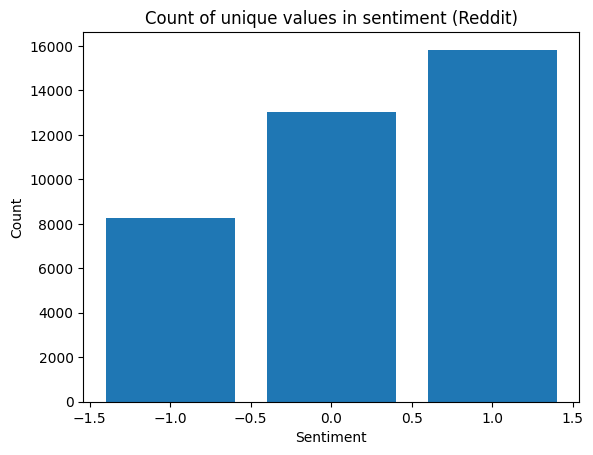

In [13]:
# Count the number of rows of each sentiment values
unique_counts = reddit_df['sentiment'].value_counts()

# Create a bar plot
plt.bar(unique_counts.index, unique_counts.values)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Count of unique values in sentiment (Reddit)')
plt.show()

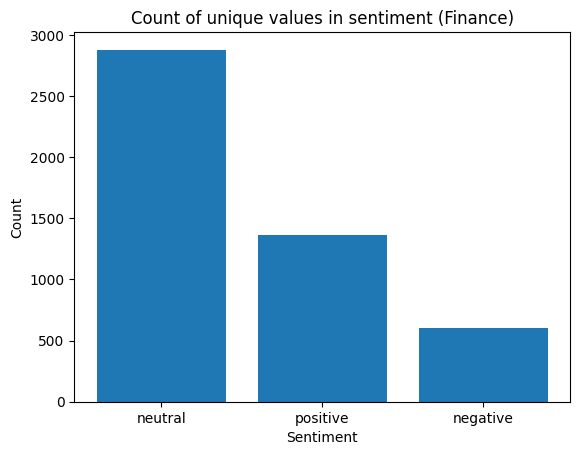

In [14]:
# Count the number of rows of each sentiment values
unique_counts2 = financial_df['sentiment'].value_counts()

# Create a bar plot
plt.bar(unique_counts2.index, unique_counts2.values)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Count of unique values in sentiment (Finance)')
plt.show()

We can see that both distribution having negative sentiment as the least, while the proportion of positive and neutral sentiment is different for both dataset. We then find the proportion of the sentiments in each dataset.

In [15]:
# Get weights for each distribution
# Reddit dataset (source)
dist_proportion1 = unique_counts / unique_counts.sum()
dist_proportion1

sentiment
 1    0.426122
 0    0.351073
-1    0.222805
Name: count, dtype: float64

In [16]:
# Get weights for each distribution
# Financial dataset (target)
dist_proportion2 = unique_counts2 / unique_counts2.sum()
dist_proportion2

sentiment
neutral     0.594098
positive    0.281263
negative    0.124639
Name: count, dtype: float64

In [17]:
# [negative, neutral, positive]
weights = [0.13, 0.59, 0.28]
class_weights = torch.FloatTensor(weights).to(device)

In [18]:
reddit_class_label = ['-1.0', '0.0', '1.0']
financial_class_label = ['negative', 'neutral', 'positive']

In [19]:
# Pre-trained model from hugging face
# We use cased model as upper case and lower case might have different meanings
BERT_MODEL_NAME = 'bert-base-cased'

# Get tokenizer from the pre-trained model
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [20]:
# Checking some of the common BERT tokens
print(tokenizer.sep_token, tokenizer.sep_token_id) # marker for ending of a sentence
print(tokenizer.cls_token, tokenizer.cls_token_id) # start of each sentence, so BERT knows we’re doing classification
print(tokenizer.pad_token, tokenizer.pad_token_id) # special token for padding
print(tokenizer.unk_token, tokenizer.unk_token_id) # tokens not found in training set 

[SEP] 102
[CLS] 101
[PAD] 0
[UNK] 100


Following that, we count the length of each reviews. Since BERT model only accepts input having max length of 512, we truncate the reviews more than 512 tokens and append to the array for histogram plot later.

In [21]:
# Store length of each review 
reddit_token_lens = []

# Iterate through each review and get the length
# If the length is more than 512 then we truncate the words to only 512 words
# BERT model only accepts maximum word length of 512
for txt in reddit_df['review']:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    reddit_token_lens.append(len(tokens))

Text(0.5, 1.0, 'Number of tokens per review (Reddit)')

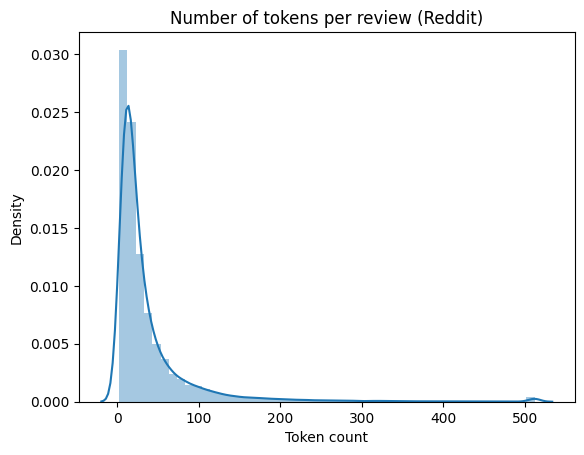

In [22]:
# Plot the distribution of review lengths 
sns.distplot(reddit_token_lens)
plt.xlabel('Token count')
plt.title('Number of tokens per review (Reddit)')

In [23]:
# Store length of each review 
financial_token_lens = []

# Iterate through each review and get the length
# If the length is more than 512 then we truncate the words to only 512 words
# BERT model only accepts maximum word length of 512
for txt in financial_df['review']:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    financial_token_lens.append(len(tokens))

Text(0.5, 1.0, 'Number of tokens per review (Financial)')

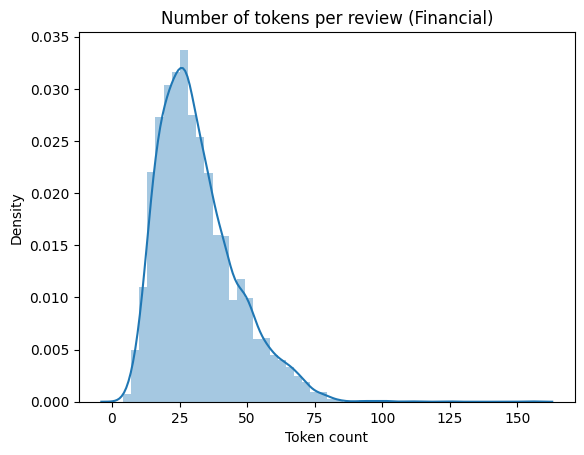

In [24]:
sns.distplot(financial_token_lens)
plt.xlabel('Token count')
plt.title('Number of tokens per review (Financial)')

Since most data can be covered with max_length of 75, hence we will proceed with MAX_LENGTH = 75.

In [25]:
MAX_LENGTH = 75

## Preparation of Dataset
We will split the dataset with 25% test set. This is because financial dataset is smaller therefore allocating a larger proportion of test data in the test set.

In [26]:
# Random split the dataset into train set and test set
# Financial data has higher test ratio due to lesser data
reddit_train, reddit_test = train_test_split(reddit_df, test_size=0.25, random_state=RANDOM_SEED)
financial_train, financial_test = train_test_split(financial_df, test_size=0.25, random_state=RANDOM_SEED)

print(reddit_train.shape, reddit_test.shape, financial_train.shape, financial_test.shape)

(27861, 3) (9288, 3) (3634, 3) (1212, 3)


In [27]:
class RedditDataset(Dataset):
    # Constructor function 
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    # Length magic method
    def __len__(self):
        return len(self.reviews)
    
    # Get item magic method
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]
        
        # Encode the review text to the format expected by the model 
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,            # Add special tokens like [CLS] and [SEP]
            max_length=self.max_len,            # Set the maximum length for padding/truncation
            padding='max_length',               # Pad sequences to the max length
            return_attention_mask=True,         # Return the attention mask (1 for tokens, 0 for padding)
            return_token_type_ids=False,        # Skip token type IDs (not needed for single-sentence tasks)
            truncation=True,                    # Truncate longer sequences to max_length
            return_tensors='pt'                 # Return PyTorch tensors
        )
        
        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }
    
class FinancialDataset(Dataset):
    # Constructor Function 
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    # Length magic method
    def __len__(self):
        return len(self.reviews)
    
    # get item magic method
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]
        
        # Encode the review text to the format expected by the model 
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,            # Add special tokens like [CLS] and [SEP]
            max_length=self.max_len,            # Set the maximum length for padding/truncation
            padding='max_length',               # Pad sequences to the max length
            return_attention_mask=True,         # Return the attention mask (1 for tokens, 0 for padding)
            return_token_type_ids=False,        # Skip token type IDs (not needed for single-sentence tasks)
            truncation=True,                    # Truncate longer sequences to max_length
            return_tensors='pt'                 # Return PyTorch tensors
        )
        
        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

In [28]:
# Prepare data to be loaded to the model
def prepare_dataloader(df, tokenizer, max_len, batch_size, dataset = 'reddit', df_type = 'train'):
    shuffle = True 

    if type == 'reddit':
        data = RedditDataset(
            reviews=df['review'].to_numpy(),
            targets=df['sentiment_enc'].to_numpy(),
            tokenizer=tokenizer,
            max_len=max_len
        )
    else:
        data = FinancialDataset(
            reviews=df['review'].to_numpy(),
            targets=df['sentiment_enc'].to_numpy(),
            tokenizer=tokenizer,
            max_len=max_len
        )

    # Set shuffle=True for train datasets
    if df_type == 'train':
        shuffle = True
    else:
        shuffle = False
        
    return DataLoader(data, batch_size=batch_size,num_workers=0, shuffle=shuffle)

In [29]:
BATCH_SIZE = 16

reddit_train_dataloader = prepare_dataloader(reddit_train, tokenizer, MAX_LENGTH, 128, "reddit", 'train')
reddit_test_dataloader = prepare_dataloader(reddit_test, tokenizer, MAX_LENGTH, 128, "reddit", 'test')

financial_train_dataloader = prepare_dataloader(financial_train, tokenizer, MAX_LENGTH, BATCH_SIZE, "financial", 'train')
financial_test_dataloader = prepare_dataloader(financial_test, tokenizer, MAX_LENGTH, BATCH_SIZE, "financial", 'test')

In [30]:
# Build the Sentiment Classifier class 
class SentimentClassifier(nn.Module):
    
    # Constructor class 
    def __init__(self, num_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(BERT_MODEL_NAME)
        self.drop = nn.Dropout(p=0.2)
        self.out = nn.Linear(self.bert.config.hidden_size, num_classes)
    
    # Forward propagaion class
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output  # Corrected to use pooler_output
        #  Add a dropout layer 
        output = self.drop(pooled_output)
        logits = self.out(output)
        return F.softmax(logits, dim=1) # Apply softmax layer to get the probabilities

In [31]:
# training function for one epoch
def train_model(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    losses = []
    correct_predictions = 0
    
    model.train()
    
    for data in data_loader:
        input_ids = data["input_ids"].to(device)
        attention_mask = data["attention_mask"].to(device)
        targets = data["targets"].to(device)
        
        # Forward pass
        predictions = model(input_ids=input_ids,attention_mask=attention_mask)
        
        _, preds = torch.max(predictions, dim=1)
        loss = loss_fn(predictions, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.detach().item())  # Use detach() to avoid storing computation graph
        
        # Backward prop
        loss.backward()
        
        # Gradient Descent
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # avoid exploding and vanishing gradients
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    
    return correct_predictions.double() / n_examples, torch.mean(torch.tensor(losses)).item()

# Evaluate model performance
def eval_model(model, data_loader, loss_fn, device, n_examples):
    losses = []
    correct_predictions = 0

    model.eval()
    
    with torch.no_grad():
        for data in data_loader:
            input_ids = data["input_ids"].to(device)
            attention_mask = data["attention_mask"].to(device)
            targets = data["targets"].to(device)

            # Forward pass
            predictions = model(input_ids=input_ids,attention_mask=attention_mask)

            _, preds = torch.max(predictions, dim=1)
            loss = loss_fn(predictions, targets)
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.detach().item())  # Use detach() to avoid storing computation graph

    # Calculate accuracy and average loss
    accuracy = correct_predictions.double() / n_examples
    avg_loss = torch.mean(torch.tensor(losses)).item()
    
    return accuracy, avg_loss

# Early Stopping class
class EarlyStopper:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

## Baseline Model: Transfer Learning directly on Financial Dataset

Using the BERT pre-trained dataset, we first try to adapt directly to the financial dataset. This model serve as the baseline accuracy for our project.

In [32]:
patience = 3
MAX_EPOCHS = 50

# Initialise the SentimentClassifier model and move the model to GPU
model1 = SentimentClassifier(len(financial_class_label))
model1 = model1.to(device)

# AdamW - Adam weight decay
optimizer1 = torch.optim.AdamW(model1.parameters(), lr=2e-5)
total_steps = len(financial_train_dataloader) * MAX_EPOCHS

# Set up a learning rate scheduler with linear decay from 2e-5 to 0 over the entire training period
# num_warmup_steps=0 means the learning rate starts at 2e-5 from the beginning
scheduler1 = get_linear_schedule_with_warmup(optimizer1, num_warmup_steps=0, num_training_steps=total_steps)

# Define a weighted cross-entropy loss function to handle class imbalance
loss_fn1 = nn.CrossEntropyLoss(weight=class_weights).to(device) 
early_stopper = EarlyStopper(patience=patience)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [33]:
# Freeze first 7 layers for faster model training
stop_layer = 'bert.encoder.layer.7.attention.self.query.weight'
for name, param in model1.named_parameters():
    if stop_layer in name: # stop layer
        break
    param.requires_grad = False

In [34]:
%%time

# Initialize history dictionary for tracking metrics
history1 = {
    'train_acc': [],
    'train_loss': [],
    'test_acc': [],
    'test_loss': []
}

for epoch in range(MAX_EPOCHS):
    
    # Training phase
    train_acc, train_loss = train_model(model1, financial_train_dataloader, loss_fn1,
                                       optimizer1, device, scheduler1, len(financial_train))

    # Evaluation phase
    test_acc, test_loss = eval_model(model1, financial_test_dataloader, loss_fn1,
                                          device, len(financial_test))
    
    # Move metrics to CPU for compatibility
    train_acc = train_acc.cpu()
    test_acc = test_acc.cpu()

    # Record metrics in history dictionary
    history1['train_acc'].append(train_acc)
    history1['train_loss'].append(train_loss)
    history1['test_acc'].append(test_acc)
    history1['test_loss'].append(test_loss)
    
    print(f'Epoch [{epoch + 1}/{MAX_EPOCHS}] Train loss {train_loss:.4f}, Train accuracy {train_acc:.4f}, Test loss {test_loss:.4f}, Test accuracy {test_acc:.4f}')
    # Early stopping check
    if early_stopper.early_stop(test_loss): 
        print("Early stopping triggered.")
        break

Epoch [1/50] Train loss 0.7758, Train accuracy 0.6423, Test loss 0.7266, Test accuracy 0.7087
Epoch [2/50] Train loss 0.7162, Train accuracy 0.7135, Test loss 0.6868, Test accuracy 0.7426
Epoch [3/50] Train loss 0.6967, Train accuracy 0.7378, Test loss 0.6780, Test accuracy 0.7566
Epoch [4/50] Train loss 0.6793, Train accuracy 0.7622, Test loss 0.6731, Test accuracy 0.7739
Epoch [5/50] Train loss 0.6598, Train accuracy 0.7895, Test loss 0.6660, Test accuracy 0.7855
Epoch [6/50] Train loss 0.6547, Train accuracy 0.7977, Test loss 0.6824, Test accuracy 0.7781
Epoch [7/50] Train loss 0.6472, Train accuracy 0.8085, Test loss 0.6657, Test accuracy 0.7896
Epoch [8/50] Train loss 0.6487, Train accuracy 0.8054, Test loss 0.6736, Test accuracy 0.7805
Epoch [9/50] Train loss 0.6407, Train accuracy 0.8129, Test loss 0.6646, Test accuracy 0.7797
Epoch [10/50] Train loss 0.6386, Train accuracy 0.8156, Test loss 0.6925, Test accuracy 0.7756
Epoch [11/50] Train loss 0.6337, Train accuracy 0.8211, Tes

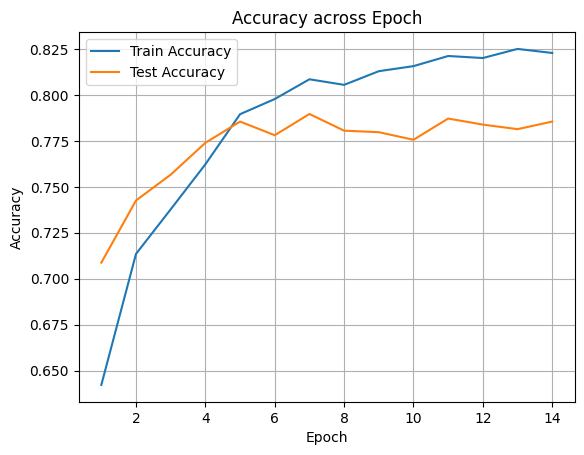

In [35]:
# Plot training and validation accuracy
plt.plot(range(1, len(history1['train_acc'])+1), history1['train_acc'], label='Train Accuracy')
plt.plot(range(1, len(history1['test_acc'])+1), history1['test_acc'], label='Test Accuracy')

# Set title, x and y labels, legends 
plt.title('Accuracy across Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

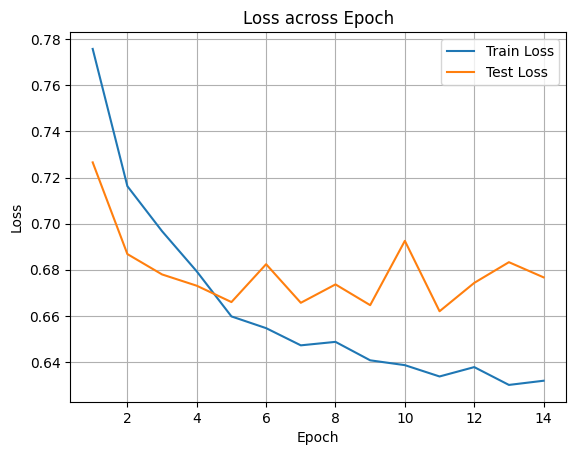

In [36]:
# Plot training and validation loss
plt.plot(range(1, len(history1['train_loss'])+1), history1['train_loss'], label='Train Loss')
plt.plot(range(1, len(history1['test_loss'])+1), history1['test_loss'], label='Test Loss')

# Graph chars
plt.title('Loss across Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

In [37]:
# Get the predictions made the model 
def get_predictions(model, dataloader):
    true_targets = []
    predicted_labels = []
    
    model.eval()
    
    with torch.no_grad():
        for d in dataloader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            predictions = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(predictions, dim=1)

            true_targets.extend(targets.cpu().numpy())
            predicted_labels.extend(preds.cpu().numpy())
    
    return true_targets, predicted_labels

F1 Score: 0.5436


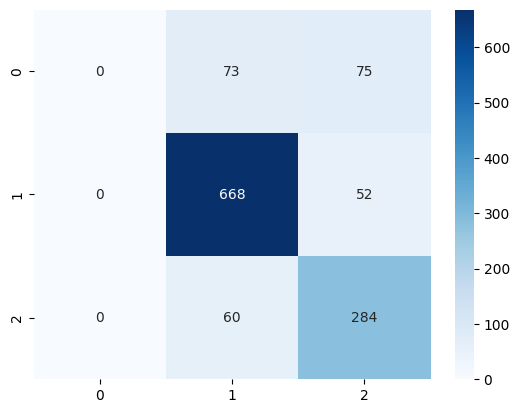

In [38]:
y_test1, y_pred1 = get_predictions(model1, financial_test_dataloader)

# Plot confusion matrix 
conf_matrix1 = confusion_matrix(y_test1, y_pred1)
sns.heatmap(conf_matrix1, annot=True, fmt="d", cmap="Blues")

# Calculate the F1 score
f1_1 = f1_score(y_test1, y_pred1, average='macro')  # Use 'weighted' for multi-class
print(f"F1 Score: {f1_1:.4f}")

## Domain Adaptation Using Source Dataset (Reddit)
Following that, we then use the pre-trained model to train on the new dataset. It will learn the features on the source dataset which will be used for sentiment classification for the target dataset later.

In [39]:
EPOCHS = 20

# Initialise the SentimentClassifier model and move the model to GPU
model2 = SentimentClassifier(len(reddit_class_label))
model2 = model2.to(device)

# AdamW - Adam weight decay
optimizer2 = torch.optim.AdamW(model2.parameters(), lr=2e-5)
total_steps = len(reddit_train_dataloader) * EPOCHS

# Set up a learning rate scheduler with linear decay from 2e-5 to 0 over the entire training period
# num_warmup_steps=0 means the learning rate starts at 2e-5 from the beginning
scheduler2 = get_linear_schedule_with_warmup(optimizer2, num_warmup_steps=0, num_training_steps=total_steps)

# Define a weighted cross-entropy loss function to handle class imbalance
loss_fn2 = nn.CrossEntropyLoss(weight=class_weights).to(device) 

In [40]:
%%time

# Initialize history dictionary for tracking metrics
history2 = {
    'train_acc': [],
    'train_loss': [],
    'test_acc': [],
    'test_loss': []
}

for epoch in range(EPOCHS):
    best_accuracy = 0.0
    
    # Training phase
    train_acc, train_loss = train_model(model2, reddit_train_dataloader, loss_fn2,
                                       optimizer2, device, scheduler2, len(reddit_train))
    
    # Evaluation phase
    test_acc, test_loss = eval_model(model2, reddit_test_dataloader, loss_fn2,
                                          device, len(reddit_test))
    
    # Move metrics to CPU for compatibility
    train_acc = train_acc.cpu()
    test_acc = test_acc.cpu()

    # Record metrics in history dictionary
    history2['train_acc'].append(train_acc)
    history2['train_loss'].append(train_loss)
    history2['test_acc'].append(test_acc)
    history2['test_loss'].append(test_loss)
    
    print(f'Epoch [{epoch + 1}/{EPOCHS}] Train loss {train_loss:.4f}, Train accuracy {train_acc:.4f}, Test loss {test_loss:.4f}, Test accuracy {test_acc:.4f}')
    
    # Save the best performing model
    if test_acc > best_accuracy: 
        torch.save(model2.state_dict(), './best_model_with_source.bin')
        best_accuracy = test_acc

Epoch [1/20] Train loss 0.7874, Train accuracy 0.6214, Test loss 0.7048, Test accuracy 0.7078
Epoch [2/20] Train loss 0.6873, Train accuracy 0.7245, Test loss 0.6815, Test accuracy 0.7302
Epoch [3/20] Train loss 0.6695, Train accuracy 0.7406, Test loss 0.6667, Test accuracy 0.7446
Epoch [4/20] Train loss 0.6479, Train accuracy 0.7969, Test loss 0.6388, Test accuracy 0.8567
Epoch [5/20] Train loss 0.6252, Train accuracy 0.8624, Test loss 0.6312, Test accuracy 0.8651
Epoch [6/20] Train loss 0.6175, Train accuracy 0.8790, Test loss 0.6294, Test accuracy 0.8777
Epoch [7/20] Train loss 0.6115, Train accuracy 0.8926, Test loss 0.6240, Test accuracy 0.8733
Epoch [8/20] Train loss 0.6073, Train accuracy 0.8990, Test loss 0.6238, Test accuracy 0.8861
Epoch [9/20] Train loss 0.6036, Train accuracy 0.9067, Test loss 0.6291, Test accuracy 0.8821
Epoch [10/20] Train loss 0.6006, Train accuracy 0.9122, Test loss 0.6259, Test accuracy 0.8939
Epoch [11/20] Train loss 0.5994, Train accuracy 0.9157, Tes

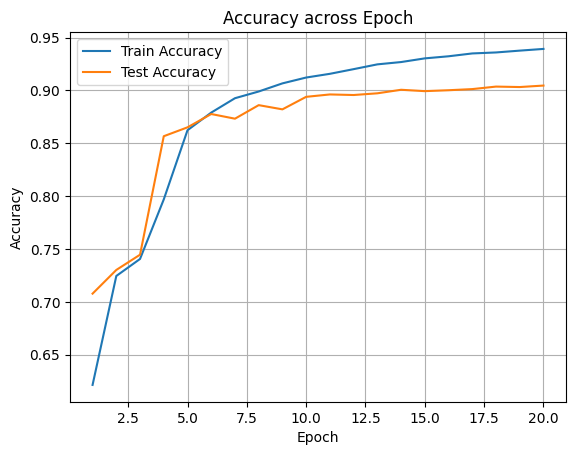

In [41]:
# Plot training and validation accuracy
plt.plot(range(1, len(history2['train_acc'])+1), history2['train_acc'], label='Train Accuracy')
plt.plot(range(1, len(history2['test_acc'])+1), history2['test_acc'], label='Test Accuracy')

# Graph chars
plt.title('Accuracy across Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

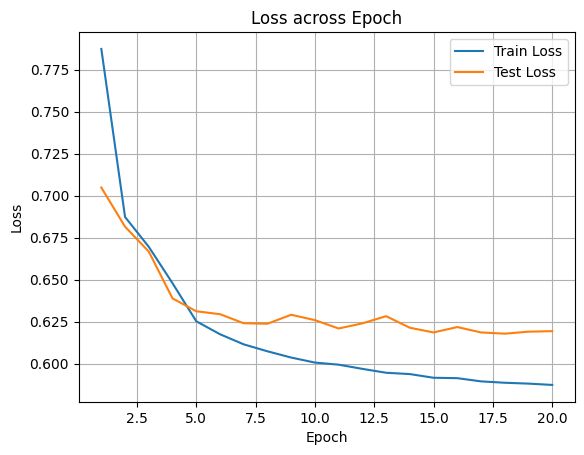

In [42]:
# Plot training and validation loss
plt.plot(range(1, len(history2['train_loss'])+1), history2['train_loss'], label='Train Loss')
plt.plot(range(1, len(history2['test_loss'])+1), history2['test_loss'], label='Test Loss')

# Graph chars
plt.title('Loss across Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

F1 Score: 0.8923


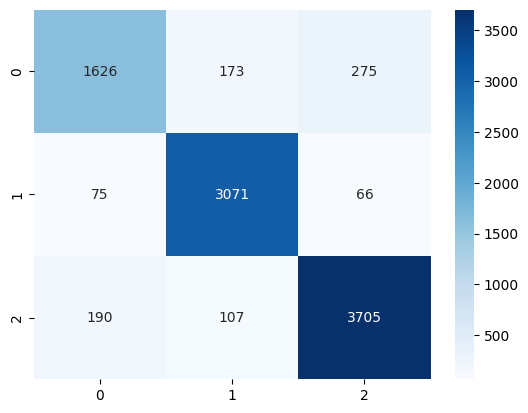

In [43]:
y_test2, y_pred2 = get_predictions(model2, reddit_test_dataloader)

# Plot confusion matrix
conf_matrix2 = confusion_matrix(y_test2, y_pred2)
sns.heatmap(conf_matrix2, annot=True, fmt="d", cmap="Blues")

# Calculate the F1 score
f1_2 = f1_score(y_test2, y_pred2, average='macro')
print(f"F1 Score: {f1_2:.4f}")

## Finetuning and Adapt to Financial Dataset

Using the trained model from reddit dataset, we will then transfer the learnings by the model to adapt to the financial domain. We will first load the best model from the source, followed by finetuning the model using target dataset. 

In [44]:
model3 = SentimentClassifier(len(financial_class_label))
model3.load_state_dict(torch.load('/kaggle/working/best_model_with_source.bin')) # Load the best model from the source
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model3 = model3.to(device) # Ensure the model is trained in GPU
print('Loaded Model 2 successfully!')
model3.eval()

Loaded Model 2 successfully!


SentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, eleme

To retain the trainings and features from the source, we will freeze the first 8 layers of BERT model. Freezing the layers will also help to speed up the model finetuning and training process.

In [45]:
# Freeze the first 7 layer to speed up model training
stop_layer = 'bert.encoder.layer.7.attention.self.query.weight'
for name, param in model3.named_parameters():
    if stop_layer in name: # stop layer
        print("Stop layer found!")
        break
    param.requires_grad = False

Stop layer found!


We then set the loss function and optimizer for the model. In consistency with the source model, we will be using back the same parameters from the source model.

In [46]:
EPOCHS = 50
patience = 5

# Using back the same optimizer. loss function and scheduler from model 2 and adapt to target model
# AdamW - Adam weight decay
optimizer2 = torch.optim.AdamW(model3.parameters(), lr=2e-5)
total_steps = len(financial_train_dataloader) * EPOCHS

# creates a schedule with learning rate that decreasesly linearly from lr=2e-5 to 0
# warmup is the period during which it increases linearly from 0 to lr=2e-5, here we set warmup = 0
scheduler2 = get_linear_schedule_with_warmup(optimizer2, num_warmup_steps=0, num_training_steps=total_steps)

# weighted cross entropy loss
loss_fn2 = nn.CrossEntropyLoss(weight=class_weights).to(device) 
early_stopper = EarlyStopper(patience=patience)

In [47]:
%%time

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Initialize history dictionary for tracking metrics
history3 = {
    'train_acc': [],
    'train_loss': [],
    'test_acc': [],
    'test_loss': []
}

for epoch in range(EPOCHS):
    
    # Train model using the optimizers, loss function and scheduler from the source model
    train_acc, train_loss = train_model(model3, financial_train_dataloader, loss_fn2,
                                       optimizer2, device, scheduler2, len(financial_train))

    # Evaluation phase
    test_acc, test_loss = eval_model(model3, financial_test_dataloader, loss_fn2,
                                          device, len(financial_test))
    
    # Move metrics to CPU for compatibility
    train_acc = train_acc.cpu()
    test_acc = test_acc.cpu()

    # Record metrics in history dictionary
    history3['train_acc'].append(train_acc)
    history3['train_loss'].append(train_loss)
    history3['test_acc'].append(test_acc)
    history3['test_loss'].append(test_loss)
    
    print(f'Epoch [{epoch + 1}/{EPOCHS}] Train loss {train_loss:.4f}, Train accuracy {train_acc:.4f}, Test loss {test_loss:.4f}, Test accuracy {test_acc:.4f}')
    # Early stopping check
    if early_stopper.early_stop(test_loss): 
        print("Early stopping triggered.")
        break

Epoch [1/50] Train loss 0.7633, Train accuracy 0.6857, Test loss 0.7114, Test accuracy 0.7995
Epoch [2/50] Train loss 0.6890, Train accuracy 0.7862, Test loss 0.6768, Test accuracy 0.8152
Epoch [3/50] Train loss 0.6664, Train accuracy 0.8178, Test loss 0.7124, Test accuracy 0.8094
Epoch [4/50] Train loss 0.6541, Train accuracy 0.8459, Test loss 0.6821, Test accuracy 0.8350
Epoch [5/50] Train loss 0.6395, Train accuracy 0.8668, Test loss 0.6720, Test accuracy 0.8424
Epoch [6/50] Train loss 0.6313, Train accuracy 0.8819, Test loss 0.6704, Test accuracy 0.8358
Epoch [7/50] Train loss 0.6263, Train accuracy 0.8919, Test loss 0.6882, Test accuracy 0.8457
Epoch [8/50] Train loss 0.6211, Train accuracy 0.9040, Test loss 0.6880, Test accuracy 0.8457
Epoch [9/50] Train loss 0.6147, Train accuracy 0.9059, Test loss 0.6915, Test accuracy 0.8399
Epoch [10/50] Train loss 0.6128, Train accuracy 0.9130, Test loss 0.6729, Test accuracy 0.8424
Epoch [11/50] Train loss 0.6058, Train accuracy 0.9196, Tes

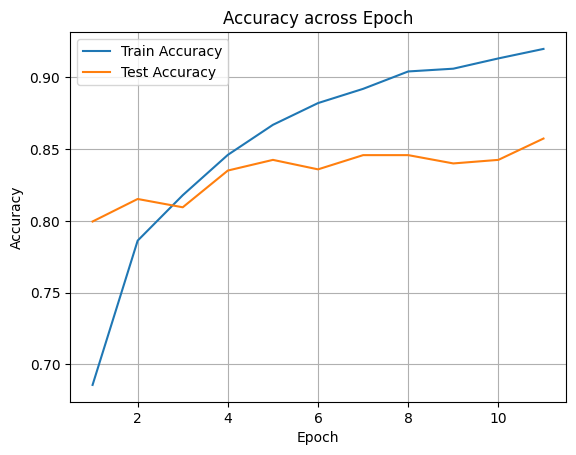

In [48]:
# Plot training and validation accuracy
plt.plot(range(1, len(history3['train_acc'])+1), history3['train_acc'], label='Train Accuracy')
plt.plot(range(1, len(history3['test_acc'])+1), history3['test_acc'], label='Test Accuracy')

# Graph chars
plt.title('Accuracy across Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

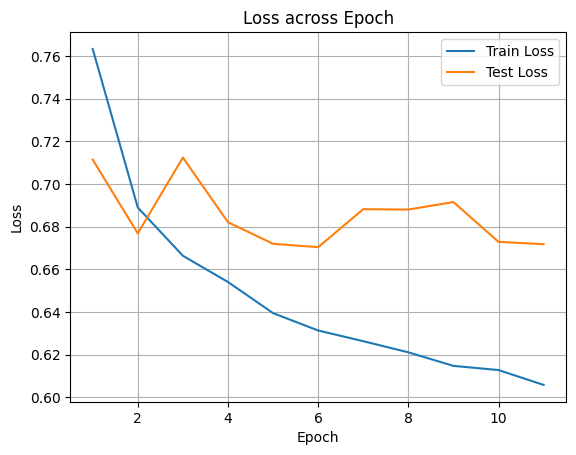

In [49]:
# Plot training and validation loss
plt.plot(range(1, len(history3['train_loss'])+1), history3['train_loss'], label='Train Loss')
plt.plot(range(1, len(history3['test_loss'])+1), history3['test_loss'], label='Test Loss')

# Graph chars
plt.title('Loss across Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

F1 Score: 0.8411


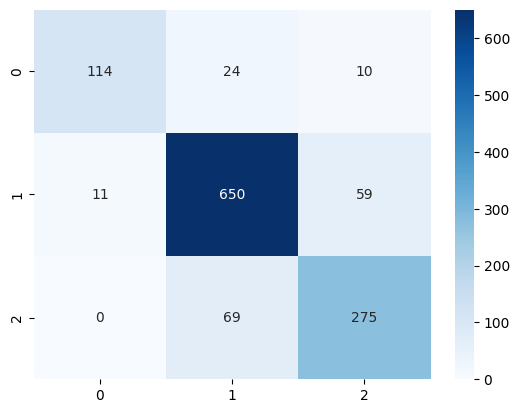

In [50]:
y_test3, y_pred3 = get_predictions(model3, financial_test_dataloader)
conf_matrix3 = confusion_matrix(y_test3, y_pred3)
sns.heatmap(conf_matrix3, annot=True, fmt="d", cmap="Blues")

# Calculate the F1 score
f1_3 = f1_score(y_test3, y_pred3, average='macro')  # Use 'weighted' for multi-class
print(f"F1 Score: {f1_3:.4f}")

## Comparison of Source and Target

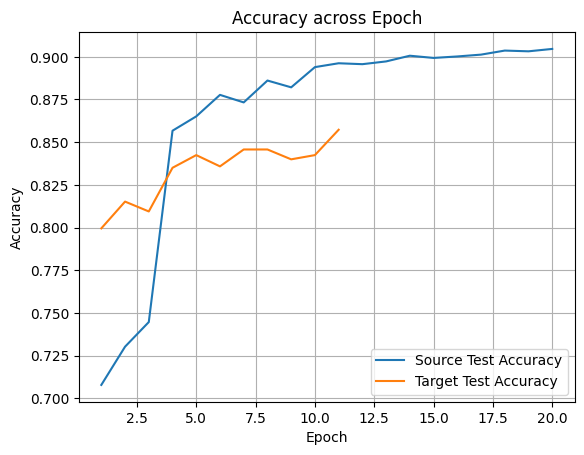

In [51]:
# Plot training and validation accuracy
plt.plot(range(1, len(history2['test_acc'])+1), history2['test_acc'], label='Source Test Accuracy')
plt.plot(range(1, len(history3['test_acc'])+1), history3['test_acc'], label='Target Test Accuracy')

# Graph chars
plt.title('Accuracy across Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)